**CORAL APPROACH**
---

Sun, B., et al. "Correlation alignment for unsupervised domain adaptation." In Domain Adaptation in Computer Vision Applications (pp. 153-171). Springer, Cham, 2017.

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

In [2]:
# DEFINE DEVICE

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

cuda


In [3]:
# GET COVARIANCE MATRICES

#------------------------------------------------
# Compute the MNIST and SVHN mean and standard 
# deviation on the training set
#------------------------------------------------

def calculate_mean_std(loader, num_channels=3):
    channel_sum, channel_squared_sum, num_elements = torch.zeros(num_channels), torch.zeros(num_channels), 0
    channel_sum, channel_squared_sum = channel_sum.to(device), channel_squared_sum.to(device)

    for data, _ in loader:
        data = data.to(device)
        channel_sum += data.sum(dim=[0, 2, 3])
        channel_squared_sum += (data ** 2).sum(dim=[0, 2, 3])
        num_elements += data.size(0) * data.size(2) * data.size(3)

    mean = channel_sum / num_elements
    std = (channel_squared_sum / num_elements - mean ** 2) ** 0.5
    return mean, std

transform_mnist = transforms.Compose([
    transforms.Resize((32, 32), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# Extract MNIST and SVHN datasets
MNIST_train = datasets.MNIST(root='./mnist_data/', train=True, transform = transform_mnist, download=True)
SVHN_train = datasets.SVHN(root='./svhn_data/', split='train', transform = transforms.ToTensor(), download=True)

# Create DataLoaders for MNIST and SVHN datasets
batch_size = 64  # Adjust as needed
MNIST_train_loader = DataLoader(MNIST_train, batch_size=batch_size, shuffle=False)
SVHN_train_loader = DataLoader(SVHN_train, batch_size=batch_size, shuffle=False)

mnist_mean, mnist_std = calculate_mean_std(MNIST_train_loader, num_channels=1)
print(f"MNIST mean: {mnist_mean}, MNIST std: {mnist_std}")
svhn_mean, svhn_std = calculate_mean_std(SVHN_train_loader, num_channels=3)
print(f"SVHN mean: {svhn_mean}, SVHN std: {svhn_std}")

#------------------------------------------------
# Normalise and flatten the MNIST and SVHN  dataset
# with real mean and standard deviation
#------------------------------------------------

# NORMALIZED DATA
#####################################

# MNIST
data = MNIST_train.data.to(device)
data = data.float() 
#reshape mnist data from 28x28 to 32x32 pixels
data = F.interpolate(data.unsqueeze(1), size=(32, 32), mode='nearest').squeeze(1)
data = data / 255
print("mnist 32x32 shape",data.shape)
data = (data - mnist_mean) / mnist_std
mnist_norm_np_flat = data.reshape(data.shape[0], -1).cpu().numpy()

# SVHN grayscale
data = SVHN_train.data /255
print(type(data))
data = torch.tensor(data, dtype=torch.float32).to(device)
data = torch.mean(data, axis=1)
data = (data - torch.mean(svhn_mean)) / torch.mean(svhn_std)
data = data.reshape(data.shape[0], -1)
svhn_gray_norm_np_flat = data.cpu().numpy()

# SVHN grayscale (by adding 3 channels into 1)
data = SVHN_train.data / 255
data = torch.tensor(data, dtype=torch.float32).to(device)
data = (data - svhn_mean[None, :, None, None]) / svhn_std[None, :, None, None]
svhn_norm_np = data.cpu().numpy()
data = data.reshape(data.shape[0], -1)
svhn_norm_np_flat = data.cpu().numpy()

print("\nNormalised MNIST min, max & shape:",mnist_norm_np_flat.shape, mnist_norm_np_flat.min(),mnist_norm_np_flat.max(), type(mnist_norm_np_flat))
print("Normalised SVHN gray min, max & shape:",svhn_gray_norm_np_flat.shape, svhn_gray_norm_np_flat.min(), svhn_gray_norm_np_flat.max(), type(svhn_gray_norm_np_flat))
print("Normalised SVHN min, max & shape:",svhn_norm_np_flat.shape, svhn_norm_np_flat.min(),svhn_norm_np_flat.max(),type(svhn_norm_np_flat))


Using downloaded and verified file: ./svhn_data/train_32x32.mat
MNIST mean: tensor([0.1288], device='cuda:0'), MNIST std: tensor([0.3061], device='cuda:0')
SVHN mean: tensor([0.4377, 0.4438, 0.4728], device='cuda:0'), SVHN std: tensor([0.1980, 0.2010, 0.1970], device='cuda:0')
mnist 32x32 shape torch.Size([60000, 32, 32])
<class 'numpy.ndarray'>

Normalised MNIST min, max & shape: (60000, 1024) -0.42061585 2.8459578 <class 'numpy.ndarray'>
Normalised SVHN gray min, max & shape: (73257, 1024) -2.2719278 2.7609339 <class 'numpy.ndarray'>
Normalised SVHN min, max & shape: (73257, 3072) -2.3995738 2.839553 <class 'numpy.ndarray'>


In [9]:
#check normalisatoin (mean and std for normalised data)
print("MNIST mean, std:",np.mean(mnist_norm_np_flat), np.std(mnist_norm_np_flat), mnist_norm_np_flat.shape )
print("SVHN gray mean, std:",np.mean(svhn_gray_norm_np_flat), np.std(svhn_gray_norm_np_flat))
print("SVHN RED mean , std:",np.mean(svhn_norm_np_flat[:,:1024]), np.std(svhn_norm_np_flat[:,:1024]))
print("SVHN GREEN mean, std:",np.mean(svhn_norm_np_flat[:,1024:2048]), np.std(svhn_norm_np_flat[:,1024:2048]))
print("SVHN BLUE mean, std:",np.mean(svhn_norm_np_flat[:,2048:]), np.std(svhn_norm_np_flat[:,2084,]))

MNIST mean, std: 0.014044313 1.0147861 (60000, 1024)
SVHN gray mean, std: 3.6790087e-07 0.9765105
SVHN RED mean , std: 2.772714e-07 0.99999774
SVHN GREEN mean, std: -9.230034e-07 1.0000021
SVHN BLUE mean, std: 2.1389458e-06 1.0261126


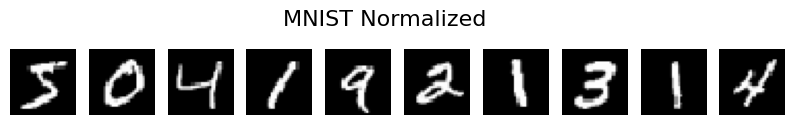

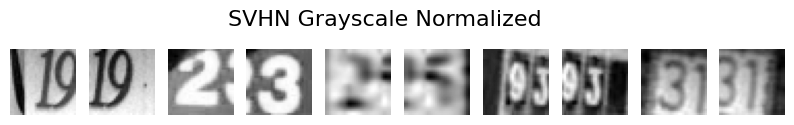

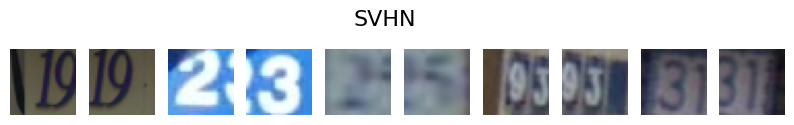

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

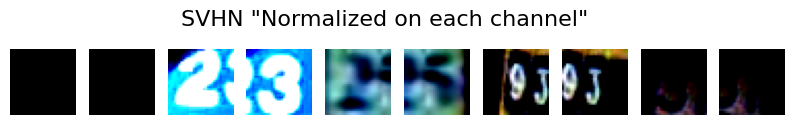

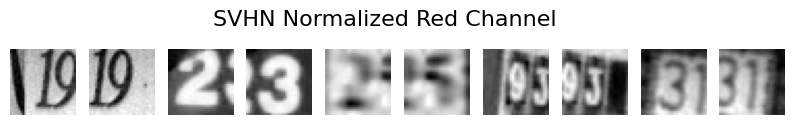

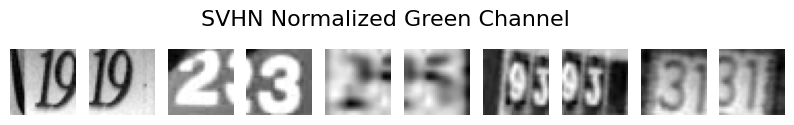

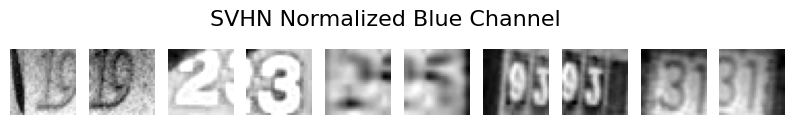

In [5]:

#print images to check normalisation

def plot_images(images, title):
    fig, axs = plt.subplots(1, 10, figsize=(10, 1.5))
    for i in range(10):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# MNIST
mnist_norm_np = mnist_norm_np_flat.reshape(-1, 32, 32)
plot_images(mnist_norm_np, 'MNIST Normalized')

# SVHN grayscale
svhn_gray_norm_np = svhn_gray_norm_np_flat.reshape(-1, 32, 32)
plot_images(svhn_gray_norm_np, 'SVHN Grayscale Normalized')

# SVHN
svhn_np_transpose = SVHN_train.data.transpose((0, 2, 3, 1))
plot_images(svhn_np_transpose, 'SVHN')

# SVHN
svhn_norm_np_transpose = svhn_norm_np.transpose((0, 2, 3, 1))
plot_images(svhn_norm_np_transpose, 'SVHN "Normalized on each channel"')
plot_images(svhn_norm_np_transpose[:,:,:,0], 'SVHN Normalized Red Channel')
plot_images(svhn_norm_np_transpose[:,:,:,1], 'SVHN Normalized Green Channel')
plot_images(svhn_norm_np_transpose[:,:,:,2], 'SVHN Normalized Blue Channel')


checking normalisation MNIST mean, std: tensor(0.0140, device='cuda:0') tensor(0.6332, device='cuda:0')

checking normalisation SVHN gray mean, std: tensor(3.6723e-07, device='cuda:0') tensor(0.9760, device='cuda:0')

checking normalisation SVHN mean, std: 0.0 0.9992
checking normalisation SVHN RED mean, std: 0.0 0.999
checking normalisation SVHN GREEN mean, std: -0.0 0.9993
checking normalisation SVHN BLUE mean, std: 0.0 0.9994

checking min max MNIST covariance matrix: -0.87091964 2.1255689
checking min max SVHN grayscale covariance matrix: 0.3238729 1.0562896
checking min max SVHN covariance matrix: 0.25726956 1.124263


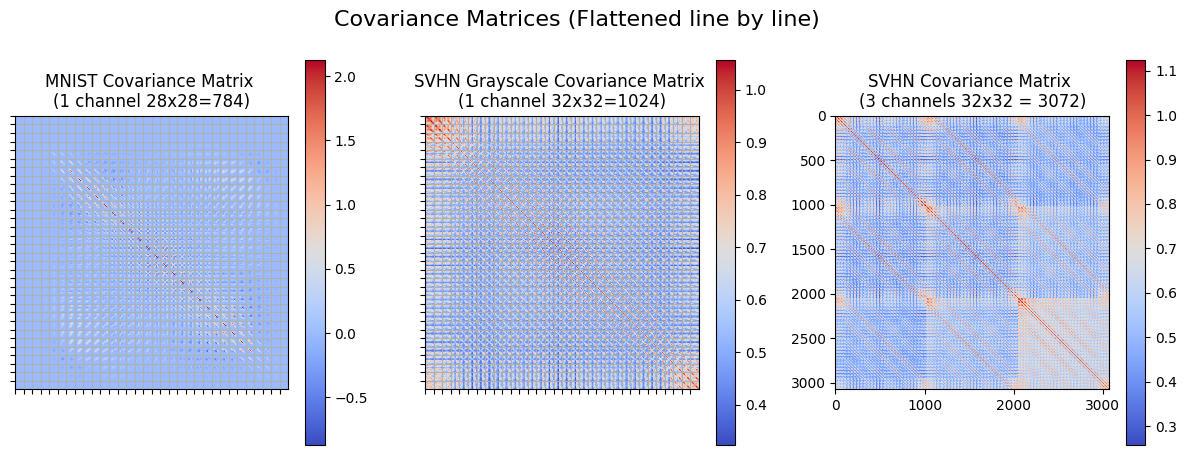

In [6]:
# COVARIANCE MATRIX
def cov_matrix(data):
    n = data.shape[0]
    if torch.is_tensor(data) == True:
        data = data.float().to(device)
    else:
        data = torch.tensor(data, dtype=torch.float32).to(device)
    mean = torch.mean(data, 0) # vector size 784 or 3072
    std = torch.std(data, 0) 
    data = data - mean
    cov = torch.matmul(data.T, data) / (n - 1) # matrix size 784x784 or 3072x3072
    return cov, mean, std

# MNIST
mnist_cov, mnist_mean_, mnist_std_ = cov_matrix(mnist_norm_np_flat)
mnist_cov_np = mnist_cov.cpu().numpy()
print("checking normalisation MNIST mean, std:",torch.mean(mnist_mean_), torch.mean(mnist_std_))

# SVHN grayscale
svhn_gray_cov, svhn_gray_mean_, svhn_gray_std_ = cov_matrix(svhn_gray_norm_np_flat)
svhn_gray_cov_np = svhn_gray_cov.cpu().numpy()
print("\nchecking normalisation SVHN gray mean, std:",torch.mean(svhn_gray_mean_), torch.mean(svhn_gray_std_))

# SVHN
svhn_cov, svhn_mean_, svhn_std_ = cov_matrix(svhn_norm_np_flat)
svhn_cov_np = svhn_cov.cpu().numpy()
print("\nchecking normalisation SVHN mean, std:",np.round(torch.mean(svhn_mean_).cpu().numpy(),4), np.round(torch.mean(svhn_std_).cpu().numpy(),4))
print("checking normalisation SVHN RED mean, std:",np.round(torch.mean(svhn_mean_[:1024]).cpu().numpy(),4), np.round( torch.mean(svhn_std_[:1024]).cpu().numpy(),4))
print("checking normalisation SVHN GREEN mean, std:",np.round(torch.mean(svhn_mean_[1024:2048]).cpu().numpy(),4), np.round(torch.mean(svhn_std_[1024:2048]).cpu().numpy(),4))
print("checking normalisation SVHN BLUE mean, std:",np.round(torch.mean(svhn_mean_[2048:]).cpu().numpy(),4), np.round(torch.mean(svhn_std_[2048:]).cpu().numpy(),4))


print("\nchecking min max MNIST covariance matrix:",mnist_cov_np.min(),mnist_cov_np.max())
print("checking min max SVHN grayscale covariance matrix:",svhn_gray_cov_np.min(),svhn_gray_cov_np.max())
print("checking min max SVHN covariance matrix:",svhn_cov_np.min(),svhn_cov_np.max())

# SHOW 3 CORRELATION MATRICES (FLATTENED)
# covariance matrix is correlation matrix beacause the data is normalised

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# MNIST Correlation Matrix
ax = axs[0]  # First subplot for MNIST
im = ax.imshow(mnist_cov_np, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('MNIST Covariance Matrix \n(1 channel 28x28=784)')
fig.colorbar(im, ax=ax)

# SVHN grayscale Correlation Matrix
ax = axs[1]  # Second subplot for SVHN grayscale
im = ax.imshow(svhn_gray_cov_np, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('SVHN Grayscale Covariance Matrix \n(1 channel 32x32=1024)')
fig.colorbar(im, ax=ax)

# SVHN Correlation Matrix
ax = axs[2]  # Third subplot for SVHN
im = ax.imshow(svhn_cov_np, cmap='coolwarm', interpolation='none')
ax.set_title('SVHN Covariance Matrix \n(3 channels 32x32 = 3072)')
fig.colorbar(im, ax=ax)

# Display the subplots
plt.suptitle('Covariance Matrices (Flattened line by line)', fontsize=16)
plt.show()



In [7]:
'''# SPRIRAL FLATTENING
#####################################

def spiral_flatten_center_out(image):
    N = image.shape[0]
    output = np.zeros(N*N, dtype=image.dtype)
    x, y = N // 2 - 1, N // 2 - 1  # Start from the center for even dimensions
    dx, dy = 0, 1  # Initial direction: right
    steps = 1  # Initial steps in the current direction
    step_changes = 0  # Counts how many times we've changed steps
    index = 0  # Index for the output array

    for i in range(N * N):
        # Check if current position is valid
        if 0 <= x < N and 0 <= y < N:
            output[index] = image[x, y]
            index += 1
        # Move to the next position
        x, y = x + dx, y + dy
        steps -= 1
        # Change direction and update steps
        if steps == 0:
            dx, dy = -dy, dx  # Rotate direction
            step_changes += 1
            if step_changes % 2 == 0:
                steps = step_changes // 2 + 1
            else:
                steps = (step_changes + 1) // 2

    return output





#MNIST

data_np = MNIST_train.data.numpy()
print('MNIST size',data_np.shape)
n_images, height, width = data_np.shape

# Apply the spiral flattening to each image
data_spiral = np.zeros((n_images, height * width), dtype=data_np.dtype)
for i in range(n_images):
    data_spiral[i, :] = spiral_flatten_center_out(data_np[i, :, :])
cov_mnist_spiral, mean_mnist_spiral, std_mnist_spiral = cov_matrix(torch.tensor(data_spiral))
print("MNIST shape of covariance matrix, mean, sdt: ", cov_mnist_spiral.shape, mean_mnist_spiral.shape, std_mnist_spiral.shape)
corr_mnist_spiral = calculate_correlation_matrix(cov_mnist_spiral, std_mnist_spiral)
corr_mnist_spiral_np = corr_mnist_spiral.cpu().numpy()  # Convert the tensor to a numpy array

# SVHN grayscale (by adding 3 channels into 1)
data_np = SVHN_train.data # numpy array
data_np = np.mean(data_np, axis=1)
print("SVHN grayscale shape", data_np.shape)
n_images, height, width = data_np.shape

# Apply the spiral flattening to each channel of each image
data_spiral = np.zeros((n_images, height * width), dtype=data_np.dtype)
for i in range(n_images):
    data_spiral[i, :] = spiral_flatten_center_out(data_np[i, :, :])

cov_SVHN_gray_spiral, mean_SVHN_gray_spiral, std_SVHN_gray_spiral = cov_matrix(torch.tensor(data_spiral))
print("shape of covariance matrix, mean, sdt: ", cov_SVHN_gray_spiral.shape, mean_SVHN_gray_spiral.shape, std_SVHN_gray_spiral.shape)
corr_SVHN_gray_spiral = calculate_correlation_matrix(cov_SVHN_gray_spiral, std_SVHN_gray_spiral)
corr_SVHN_gray_spiral_np = corr_SVHN_gray_spiral.cpu().numpy()  # Convert the tensor to a numpy array

#SVHN

# Assuming data_np is a 4D numpy array where each slice [i,3, :, :] is an image
data_np = SVHN_train.data
print("SVHN shape", data_np.shape)
n_images, channels, height, width = data_np.shape

# Apply the spiral flattening to each channel of each image
data_spiral = np.zeros((n_images, channels * height * width), dtype=data_np.dtype)
for i in range(n_images):
    for j in range(channels):
        data_spiral[i, j * height * width:(j + 1) * height * width] = spiral_flatten_center_out(data_np[i, j, :, :])

cov_SVHN_spiral, mean_SVHN_spiral, std_SVHN_spiral = cov_matrix(torch.tensor(data_spiral))
print("shape of covariance matrix, mean, sdt: ", cov_SVHN_spiral.shape, mean_SVHN_spiral.shape, std_SVHN_spiral.shape)
corr_SVHN_spiral = calculate_correlation_matrix(cov_SVHN_spiral, std_SVHN_spiral)
corr_SVHN_spiral_np = corr_SVHN_spiral.cpu().numpy()  # Convert the tensor to a numpy array

# SHOW 3 CORRELATION MATRICES (SPIRAL FLATTENED CENTER OUT)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# MNIST Correlation Matrix
ax = axs[0]  # First subplot for MNIST
im = ax.imshow(corr_mnist_spiral_np, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_xticks(np.arange(0, 784, 28))
ax.set_yticks(np.arange(0, 784, 28))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('MNIST Correlation Matrix \n(1 channel 28x28=784)')
fig.colorbar(im, ax=ax)

# SVHN grayscale Correlation Matrix
ax = axs[1]  # Second subplot for SVHN grayscale
im = ax.imshow(corr_SVHN_gray_spiral_np, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_xticks(np.arange(0, 1024, 32))
ax.set_yticks(np.arange(0, 1024, 32))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('SVHN Grayscale Covariance Matrix \n(1 channel 32x32=1024)')
fig.colorbar(im, ax=ax)

# SVHN Correlation Matrix
ax = axs[2]  # Third subplot for SVHN
im = ax.imshow(corr_SVHN_spiral_np, cmap='coolwarm', interpolation='none')
ax.grid(True)
ax.set_title('SVHN Correlation Matrix \n(3 channels 32x32 = 3072)')
fig.colorbar(im, ax=ax)

# Display the subplots
plt.suptitle('Correlation Matrices (Spiral Flattened Center Out)', fontsize=16)
plt.show()'''



'# SPRIRAL FLATTENING\n#####################################\n\ndef spiral_flatten_center_out(image):\n    N = image.shape[0]\n    output = np.zeros(N*N, dtype=image.dtype)\n    x, y = N // 2 - 1, N // 2 - 1  # Start from the center for even dimensions\n    dx, dy = 0, 1  # Initial direction: right\n    steps = 1  # Initial steps in the current direction\n    step_changes = 0  # Counts how many times we\'ve changed steps\n    index = 0  # Index for the output array\n\n    for i in range(N * N):\n        # Check if current position is valid\n        if 0 <= x < N and 0 <= y < N:\n            output[index] = image[x, y]\n            index += 1\n        # Move to the next position\n        x, y = x + dx, y + dy\n        steps -= 1\n        # Change direction and update steps\n        if steps == 0:\n            dx, dy = -dy, dx  # Rotate direction\n            step_changes += 1\n            if step_changes % 2 == 0:\n                steps = step_changes // 2 + 1\n            else:\n      

**CORAL METHOD**
---

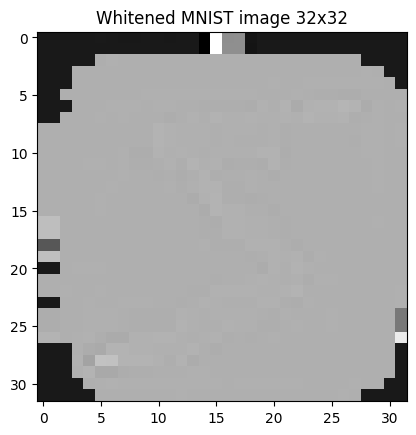

mean_whitened, std_whitened -0.050575536 -0.050575536
mnist_whitened_1024 min max shape -0.62795025 0.9533524 (60000, 1024)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mnist_colorized min max shape -3.9882774 -0.7909218 (60000, 3072)


ValueError: too many values to unpack (expected 2)

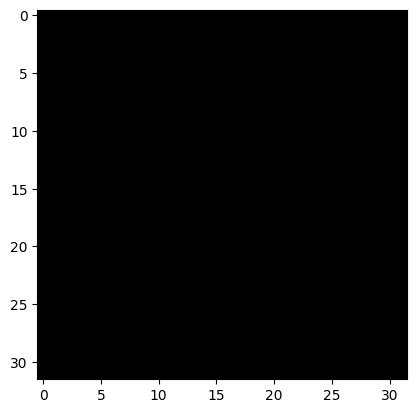

In [12]:

def whiten(data, cov_matrix):
    """
    Whitens the input data using the given covariance matrix.

    :param data: Input data as a 2D numpy array.
    :param cov_matrix: Covariance matrix as a 2D numpy array.
    :return: Whitened data as a 2D numpy array.
    """
    # Ensure input is in numpy format
    data = np.asarray(data, dtype=np.float32)
    
    # Eigen decomposition of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    eigvals[eigvals < 1e-12] = 1e-12  # Ensure numerical stability
    
    # Create the whitening matrix, which is the dot product of eigenvectors, the inverse square root of eigenvalues, and the transpose of eigenvectors
    whitening_matrix = np.dot(eigvecs, np.dot(np.diag(1.0 / np.sqrt(eigvals)), eigvecs.T))
    
    # Whitening the data
    whitened_data = np.dot(data - data.mean(axis=0), whitening_matrix)  # Subtract the mean to center the data
    
    return whitened_data /255


# Example usage
mnist_whitened_1024 = whiten(mnist_norm_np_flat, mnist_cov_np) #32x32x 1 channel
plt.imshow(mnist_whitened_1024[0].reshape(32,32), cmap='gray')
plt.title('Whitened MNIST image 32x32')
plt.show()

print("mean_whitened, std_whitened",mnist_whitened_1024.mean(), mnist_whitened_1024.mean())
print("mnist_whitened_1024 min max shape",mnist_whitened_1024.min(),mnist_whitened_1024.max(),mnist_whitened_1024.shape)


def color(data, cov_matrix):
    """
    Colorizes the input data using the given covariance matrix.

    :param data: Input data as a 2D numpy array.
    :param cov_matrix: Covariance matrix as a 2D numpy array.
    :return: Colorized data as a 2D numpy array.
    """
    # Ensure input is in numpy format
    data = np.asarray(data, dtype=np.float32)
    
    # Eigen decomposition of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    eigvals[eigvals < 1e-12] = 1e-12  # Ensure numerical stability
    colorization_matrix = np.dot(eigvecs, np.dot(np.diag(np.sqrt(eigvals)), eigvecs.T))
    
    # Colorizing the data
    colorized_data = np.dot(data, colorization_matrix)
    
    return colorized_data

mnist_whitened_3072 = np.repeat(mnist_whitened_1024, 3, axis=1) # 32 x 32 x 3 channels
mnist_colorized = color(mnist_whitened_3072, svhn_cov_np)
print("mnist_colorized min max shape",mnist_colorized.min(),mnist_colorized.max(),mnist_colorized.shape)
# Example usage
plt.imshow(mnist_colorized[0].reshape(32, 32, 3)/255)

mean_colorised, std_colorised = calculate_mean_std(mnist_colorized, num_channels=3)
print("mean_colorised, std_colorised",mean_colorised, std_colorised)


In [ ]:
# CORAL METHOD
#####################################

def whiten(data, cov_matrix):
    """
    Whitens the input data using the given covariance matrix.

    :param data: Input data as a 2D numpy array.
    :param cov_matrix: Covariance matrix as a 2D numpy array.
    :return: Whitened data as a 2D numpy array.
    """
    # Ensure input is in numpy format
    data = np.asarray(data, dtype=np.float32)
    
    # Eigen decomposition of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    eigvals[eigvals < 1e-12] = 1e-12  # Ensure numerical stability
    whitening_matrix = np.dot(eigvecs, np.dot(np.diag(1.0 / np.sqrt(eigvals)), eigvecs.T))
    
    # Whitening the data
    whitened_data = np.dot(data, whitening_matrix)
    
    return whitened_data

# Example usage
mnist_whitened = whiten(mnist_norm_np_flat, mnist_cov_np)
plt.imshow(mnist_whitened[0].reshape(28, 28), cmap='gray')
plt.title('Whitened MNIST image')
plt.show()

def coral(mnist_data, corr_mnist, corr_svhn):
    """
    Adjust the MNIST data to have similar statistical properties to SVHN data using the CORAL method.

    :param mnist_data: MNIST data as a 2D numpy array (flattened, single channel).
    :param corr_mnist: Precomputed MNIST correlation matrix.
    :param corr_svhn: Precomputed SVHN correlation matrix.
    :return: Transformed MNIST data as a 2D numpy array (flattened, three channels).
    """
    # Ensure input is in numpy format
    mnist_data = np.asarray(mnist_data, dtype=np.float32)
    
    # Step 1: Whiten MNIST data using its correlation matrix
    mnist_eigvals, mnist_eigvecs = np.linalg.eigh(corr_mnist)
    mnist_eigvals[mnist_eigvals < 1e-12] = 1e-12
    mnist_whitening_matrix = np.dot(mnist_eigvecs, np.diag(1.0 / np.sqrt(mnist_eigvals)))
    print("shape of whitening matrix:", mnist_whitening_matrix.shape)
    mnist_whitened = np.dot(mnist_data, mnist_whitening_matrix)
    print("shape of whitened data:", mnist_whitened.shape)

    # Step 2: Resize MNIST to 28x28 then interpolate to 32x32 (no padding) then flatten
    mnist_whitened_28 = torch.tensor(mnist_whitened.reshape(-1, 28, 28))
    mnist_whitened_32 = F.interpolate(mnist_whitened_28.unsqueeze(1), size=32, mode='bilinear', align_corners=False).squeeze(1)
    mnist_whitened = mnist_whitened_32.reshape(-1, 1024).cpu().numpy()

    # Step 3 replicating channels
    mnist_whitened_replicated = np.repeat(mnist_whitened, 3, axis=1)
    
    # Prepare the transformed MNIST data container
    transformed_mnist = np.zeros((mnist_data.shape[0], 3 * 1024), dtype=np.float32)
    
    # Step 4: Color transformed MNIST using SVHN correlation matrix for each channel
    for i in range(3):  # Iterate over the three channels
        # Extract the SVHN correlation matrix for each channel
        start_idx = i * 1024
        end_idx = (i + 1) * 1024
        svhn_channel_corr = corr_svhn[start_idx:end_idx, start_idx:end_idx]
        
        # Eigen decomposition of the SVHN channel correlation matrix
        svhn_channel_eigvals, svhn_channel_eigvecs = np.linalg.eigh(svhn_channel_corr)
        svhn_channel_eigvals[svhn_channel_eigvals < 1e-12] = 1e-12
        svhn_channel_coloring_matrix = np.dot(svhn_channel_eigvecs, np.diag(np.sqrt(svhn_channel_eigvals)))
        
        # Color the MNIST data for this channel
        transformed_mnist[:, start_idx:end_idx] = np.dot(mnist_whitened_replicated[:, start_idx:end_idx], svhn_channel_coloring_matrix)
    
    return transformed_mnist

# Example usage
# mnist_data should be a flattened 2D array of MNIST images with shape (num_samples, 784)
# corr_mnist and corr_svhn are the precomputed correlation matrices for MNIST and SVHN datasets, respectively
# transformed_mnist = coral(mnist_data, corr_mnist, corr_svhn)



# Apply CORAL to the normalized MNIST and SVHN data
mnist_like_svhn_flat = coral(mnist_norm_np_flat, mnist_cov_np, svhn_cov_np)
print("shape of transformed MNIST data:", mnist_like_svhn_flat.shape)
mnist_like_svhn = mnist_like_svhn_flat.reshape(-1, 3, 32, 32)

print("checking normalisation MNIST mean, std:",np.mean(mnist_like_svhn_flat), np.std(mnist_like_svhn_flat))
# display first image
plt.imshow(mnist_like_svhn[0].transpose(1, 2, 0))
plt.axis('off')
plt.title('Transformed MNIST image')





In [ ]:
'''# Show the first 10 images of the original and transformed MNIST data
fig, axs = plt.subplots(3, 10, figsize=(20, 4))

for i in range(10):
    # Original MNIST
    axs[0, i].imshow(mnist_norm_np_flat[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')

RED = mnist_like_svhn_flat[:,:1024]
GREEN = mnist_like_svhn_flat[:,1024:2048]
BLUE = mnist_like_svhn_flat[:,2048:]
mnist_like_svhn_img = np.stack((RED, GREEN, BLUE), axis=-1).reshape(-1, 32, 32, 3)
print("shape of transformed MNIST img:", mnist_like_svhn_img.shape)
for i in range(10):
    # Transformed MNIST
    axs[2, i].imshow(RED[i].reshape(32, 32), cmap='gray')
    axs[2, i].axis('off')
for i in range(10):
    # Transformed MNIST
    axs[1, i].imshow(mnist_like_svhn_img[i])
    axs[1, i].axis('off')'''

In [ ]:
# DOWNLOAD DATA 

# DOWNLOAD, RESIZE & NORMALIZE MNIST DATASET  (32x32x3 instead of originl 28x28x1)

from torchvision import datasets, transforms
import torch

# Define the transform to resize the image to 32x32 and replicate to 3 channels
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
])

# Download and load the dataset with the defined transform
train_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset_source = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# DOWNLOAD, (RESIZE &) NORMALISE, SVHN DATASET (Stret View House Numbers)
train_dataset_target = datasets.SVHN(root='./svhn_data/', split='train', transform=transform, download=True) # transform to insure same shape and normalisation
test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)


In [ ]:
##########################################
# FUNCTIONS TO APPLY CORAL METHOD
##########################################



def compute_covariance_matrix(data):
    """
    Compute the covariance matrix for the given data.
    
    :param data: 2D array where rows are samples and columns are features.
    :return: Covariance matrix.
    """
    scaler = StandardScaler(with_std=False)
    data = scaler.fit_transform(data)  # Mean centering the data
    covariance_matrix = np.cov(data, rowvar=False)
    return covariance_matrix

def coral(source_data, target_data):
    """
    Perform CORAL on the source data to match the target data.
    
    :param source_data: Source data (MNIST) as a 2D numpy array.
    :param target_data: Target data (SVHN) as a 2D numpy array.
    :return: Transformed source data as a 2D numpy array.
    """
    # Compute the covariance matrices
    source_cov = compute_covariance_matrix(source_data)
    target_cov = compute_covariance_matrix(target_data)

    # Compute the source data whitening matrix
    source_cov_eigvals, source_cov_eigvecs = np.linalg.eigh(source_cov)
    source_whitening_matrix = np.dot(source_cov_eigvecs, np.diag(1.0 / np.sqrt(source_cov_eigvals)))
    
    # Compute the target data coloring matrix
    target_cov_eigvals, target_cov_eigvecs = np.linalg.eigh(target_cov)
    target_coloring_matrix = np.dot(target_cov_eigvecs, np.diag(np.sqrt(target_cov_eigvals)))

    # Transform the source data
    source_data_whitened = np.dot(source_data, source_whitening_matrix)
    source_data_colored = np.dot(source_data_whitened, target_coloring_matrix)

    return source_data_colored

# Flatten the images and convert to numpy arrays
def extract_features_and_flatten(dataset):
    dataset_flattened = []
    for data, _ in dataset:
        # Flatten the image data and convert to a numpy array
        data = data.numpy().flatten()
        dataset_flattened.append(data)
    return np.array(dataset_flattened)

# Extract features from datasets
source_features = extract_features_and_flatten(train_dataset_source)
target_features = extract_features_and_flatten(train_dataset_target)

# Apply CORAL to align the source dataset to the target dataset
source_features_aligned = coral(source_features, target_features)

# Convert the transformed features back into PyTorch tensors
source_features_aligned_tensor = torch.tensor(source_features_aligned, dtype=torch.float32)

# Here you would reshape the tensor and train your classifier using the aligned data
# This part is not shown and would depend on your classifier training procedure.


In [ ]:
class FlattenTransform:
    def __call__(self, x):
        return x.view(-1)
    
transform_mnist = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor value in [0, 1]
    transforms.Normalize(mnist_mean, mnist_std),  # Normalize with real mean and standard deviation
    FlattenTransform(),  # Flatten the images
])

transform_svhn = transforms.Compose([
    transforms.ToTensor(), # Convert to tensor value in [0, 1]
    transforms.Normalize(svhn_mean, svhn_std), # Normalize with real mean and standard deviation
    FlattenTransform(),  # Flatten the images
])

MNIST_train_flat = datasets.MNIST(root='./mnist_data/', train=True, transform = transform_mnist, download=True)
SVHN_train_flat = datasets.SVHN(root='./svhn_data/', split='train', transform = transform_svhn, download=True)

MNIST_train_loader_flat = DataLoader(MNIST_train_flat, batch_size=batch_size, shuffle=False)
SVHN_train_loader_flat = DataLoader(SVHN_train_flat, batch_size=batch_size, shuffle=False)

print("MNIST shape: ", MNIST_train_flat.data.shape)
print("SVHN shape: ", SVHN_train_flat.data.shape)